# Micro-Climate Building Context Visualization 

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.2 MB/s eta 0:00:00


In [2]:
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import pandas as pd
import rtree
from shapely.geometry import Polygon, MultiPolygon, Point
import shapely.wkt as wkt
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import csv
import os

# Swiss Dwelling Data Preparation

In [4]:
#mount google drive
drive.mount ('/content/gdrive', force_remount=True)
folder = "/content/gdrive/My Drive/Archilyse/context/v2.2.1"
os.chdir(folder)

Mounted at /content/gdrive


In [5]:
df_simulation = pd.read_csv("simulations.csv")

In [6]:
df_geometry = pd.read_csv("geometries.csv")

In [ ]:
list(df_simulation.columns)

['site_id',
 'building_id',
 'plan_id',
 'floor_id',
 'unit_id',
 'area_id',
 'unit_usage',
 'apartment_id',
 'layout_compactness',
 'layout_is_navigable',
 'layout_mean_walllengths',
 'layout_area',
 'layout_net_area',
 'layout_room_count',
 'layout_std_walllengths',
 'layout_area_type',
 'layout_number_of_doors',
 'layout_number_of_windows',
 'layout_has_sink',
 'layout_has_shower',
 'layout_has_bathtub',
 'layout_has_stairs',
 'layout_has_entrance_door',
 'layout_has_toilet',
 'layout_perimeter',
 'layout_door_perimeter',
 'layout_window_perimeter',
 'layout_open_perimeter',
 'layout_railing_perimeter',
 'layout_connects_to_bathroom',
 'layout_connects_to_private_outdoor',
 'floor_number',
 'floor_has_elevator',
 'sun_201803210800_max',
 'sun_201803210800_mean',
 'sun_201803210800_median',
 'sun_201803210800_min',
 'sun_201803210800_p20',
 'sun_201803210800_p80',
 'sun_201803210800_stddev',
 'sun_201803211000_max',
 'sun_201803211000_mean',
 'sun_201803211000_median',
 'sun_20180321

In [7]:
df_simulation = df_simulation[['site_id','building_id','floor_id','unit_id','area_id','apartment_id','sun_201803210800_max','sun_201803211600_max', 'view_sky_max','view_greenery_max', 'window_noise_traffic_day_max','layout_number_of_windows']]

In [8]:
df_simulation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347252 entries, 0 to 347251
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   site_id                       347252 non-null  int64  
 1   building_id                   347252 non-null  int64  
 2   floor_id                      347252 non-null  int64  
 3   unit_id                       347252 non-null  int64  
 4   area_id                       347252 non-null  int64  
 5   apartment_id                  347252 non-null  object 
 6   sun_201803210800_max          347051 non-null  float64
 7   sun_201803211600_max          347051 non-null  float64
 8   view_sky_max                  347051 non-null  float64
 9   view_greenery_max             347051 non-null  float64
 10  window_noise_traffic_day_max  347252 non-null  float64
 11  layout_number_of_windows      347252 non-null  int64  
dtypes: float64(5), int64(6), object(1)
memory us

In [9]:
df_geometry_clean = df_geometry[['area_id','entity_type','entity_subtype','geometry']]

In [10]:
df_geometry_clean.head()

,area_id,entity_type,entity_subtype,geometry
0,665573.0,area,LOBBY,POLYGON ((1.6012257467443494 3.447625767845691...
1,368602.0,area,STOREROOM,POLYGON ((1.8167841404172833 3.351365524353243...
2,368605.0,area,BALCONY,POLYGON ((-5.8129553846558579 3.83231712863974...
3,368617.0,area,SANITARY_ROOMS,POLYGON ((0.5863531182990442 7.586188359449506...
4,368608.0,area,CLOAKROOM,POLYGON ((-3.6615420687693208 -2.0662998603049...


In [11]:
df_geometry_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3037851 entries, 0 to 3037850
Data columns (total 4 columns):
 #   Column          Dtype  
---  ------          -----  
 0   area_id         float64
 1   entity_type     object 
 2   entity_subtype  object 
 3   geometry        object 
dtypes: float64(1), object(3)
memory usage: 92.7+ MB


In [12]:
df = pd.merge(df_simulation, df_geometry_clean, on ='area_id')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1718609 entries, 0 to 1718608
Data columns (total 15 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   site_id                       int64  
 1   building_id                   int64  
 2   floor_id                      int64  
 3   unit_id                       int64  
 4   area_id                       int64  
 5   apartment_id                  object 
 6   sun_201803210800_max          float64
 7   sun_201803211600_max          float64
 8   view_sky_max                  float64
 9   view_greenery_max             float64
 10  window_noise_traffic_day_max  float64
 11  layout_number_of_windows      int64  
 12  entity_type                   object 
 13  entity_subtype                object 
 14  geometry                      object 
dtypes: float64(5), int64(6), object(4)
memory usage: 209.8+ MB


In [14]:
df_clean = df.drop_duplicates()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591144 entries, 0 to 1718608
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   site_id                       591144 non-null  int64  
 1   building_id                   591144 non-null  int64  
 2   floor_id                      591144 non-null  int64  
 3   unit_id                       591144 non-null  int64  
 4   area_id                       591144 non-null  int64  
 5   apartment_id                  591144 non-null  object 
 6   sun_201803210800_max          590943 non-null  float64
 7   sun_201803211600_max          590943 non-null  float64
 8   view_sky_max                  590943 non-null  float64
 9   view_greenery_max             590943 non-null  float64
 10  window_noise_traffic_day_max  591144 non-null  float64
 11  layout_number_of_windows      591144 non-null  int64  
 12  entity_type                   591144 non-nu

In [15]:
df = df_clean.dropna()

In [16]:
df = df[df['entity_type'] == "area"]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347046 entries, 0 to 1718608
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   site_id                       347046 non-null  int64  
 1   building_id                   347046 non-null  int64  
 2   floor_id                      347046 non-null  int64  
 3   unit_id                       347046 non-null  int64  
 4   area_id                       347046 non-null  int64  
 5   apartment_id                  347046 non-null  object 
 6   sun_201803210800_max          347046 non-null  float64
 7   sun_201803211600_max          347046 non-null  float64
 8   view_sky_max                  347046 non-null  float64
 9   view_greenery_max             347046 non-null  float64
 10  window_noise_traffic_day_max  347046 non-null  float64
 11  layout_number_of_windows      347046 non-null  int64  
 12  entity_type                   347046 non-nu

In [18]:
#number of unique ids
print(df.nunique())

site_id                           1422
building_id                       3088
floor_id                         13139
unit_id                          44407
area_id                         201011
apartment_id                     42379
sun_201803210800_max            292857
sun_201803211600_max            290699
view_sky_max                    306612
view_greenery_max               300919
window_noise_traffic_day_max    181792
layout_number_of_windows            22
entity_type                          1
entity_subtype                      18
geometry                        199003
dtype: int64


In [19]:
#Constructing GeoDataFrame from a pandas DataFrame with a column of WKT geometries:
gs = gpd.GeoSeries.from_wkt(df['geometry'])
gdf = gpd.GeoDataFrame(df, geometry=gs, crs=None)

In [ ]:
fig = plt.figure(figsize=(30, 18))
ax2 = gdf.plot('entity_subtype', cmap = "plasma", figsize=(30,30), legend=True)
ax2.figure.savefig("entity_subtype")

# Specific id 

In [36]:
#finding data about specific ids
test_floor = df.loc[df['floor_id'] == 46511]

# Normalize using Min/Max Normalization.
test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max()-test_floor['sun_201803211600_max'].min())
test_floor['view_sky_max']=(test_floor['view_sky_max']-test_floor['view_sky_max'].min())/(test_floor['view_sky_max'].max()-test_floor['view_sky_max'].min())
test_floor['view_greenery_max']=(test_floor['view_greenery_max']-test_floor['view_greenery_max'].min())/(test_floor['view_greenery_max'].max()-test_floor['view_greenery_max'].min())
test_floor['window_noise_traffic_day_max']=(test_floor['window_noise_traffic_day_max']-test_floor['window_noise_traffic_day_max'].min())/(test_floor['window_noise_traffic_day_max'].max()-test_floor['window_noise_traffic_day_max'].min())

test_floor.head()

<ipython-input-36-670edc8ae4cb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
<ipython-input-36-670edc8ae4cb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max(

,site_id,building_id,floor_id,unit_id,area_id,apartment_id,sun_201803210800_max,sun_201803211600_max,view_sky_max,view_greenery_max,window_noise_traffic_day_max,layout_number_of_windows,entity_type,entity_subtype,geometry
110835,1007,2089,46511,145646,1509404,c795e39f39b7cd2c81b89b731e3ad1f2,0.003817,0.003337,0.001025,0.037807,0.000000,0,area,CORRIDOR,"POLYGON ((19.00761 -7.93563, 18.49634 -5.78367..."
110836,1007,2089,46511,145646,1509584,c795e39f39b7cd2c81b89b731e3ad1f2,0.231691,0.217433,0.204214,0.186756,0.982556,1,area,LIVING_ROOM,"POLYGON ((18.86799 -8.13532, 19.04506 -8.09325..."
110837,1007,2089,46511,145646,1509587,c795e39f39b7cd2c81b89b731e3ad1f2,0.000000,0.000000,0.000000,0.000000,0.000000,0,area,BATHROOM,"POLYGON ((25.05492 -3.88673, 23.13299 -4.34334..."
110841,1007,2089,46511,145646,1509405,c795e39f39b7cd2c81b89b731e3ad1f2,0.071064,0.069740,0.143963,0.182933,0.650430,1,area,ROOM,"POLYGON ((20.27431 2.13528, 21.22785 -1.87826,..."
110842,1007,2089,46511,145646,1509409,c795e39f39b7cd2c81b89b731e3ad1f2,0.859887,0.779536,0.719959,0.328674,0.955871,0,area,BALCONY,"POLYGON ((26.98084 -12.92404, 26.98084 -12.924..."


<Axes: >

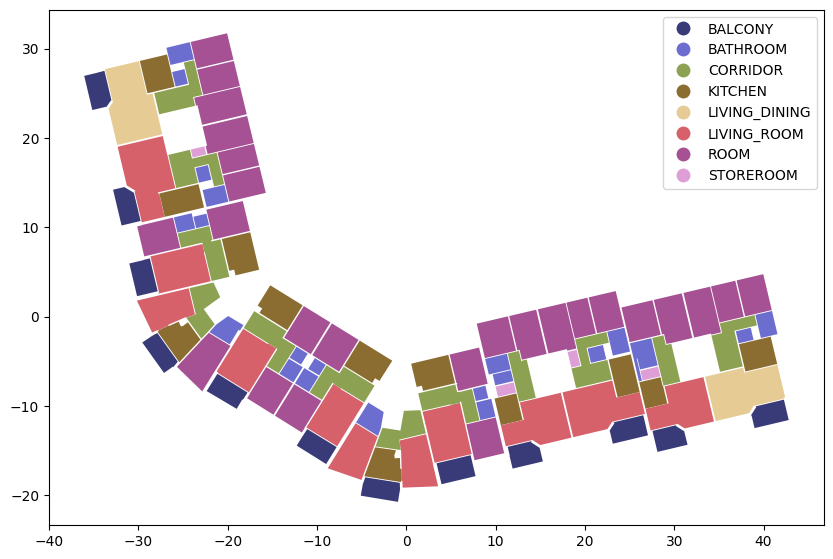

In [37]:
#first change dataframe to geopandas dataframe
gdf_test_floor = gpd.GeoDataFrame(test_floor, geometry=gs, crs=None)
gdf_test_floor.plot(column='entity_subtype', cmap="tab20b", legend=True, figsize=(10,10))

<Axes: >

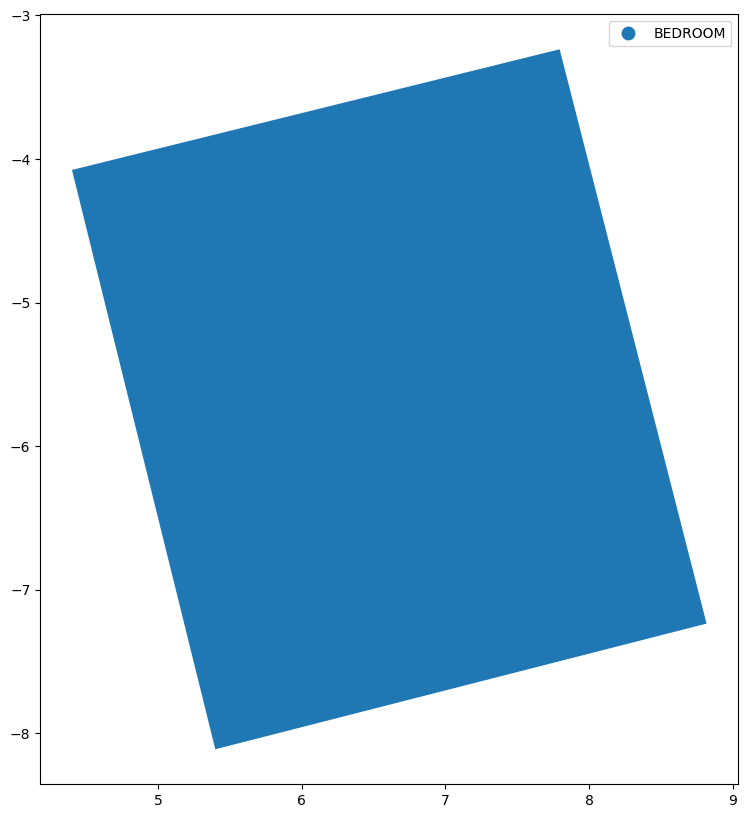

In [23]:
#finding data about specific ids
test_area = df.loc[df['area_id'] == 1509265]

#first change dataframe to geopandas dataframe
gdf_test_area = gpd.GeoDataFrame(test_area, geometry=gs, crs=None)
gdf_test_area.plot(column='entity_subtype', cmap="tab10", legend=True, figsize=(10,10))

# Context Representation

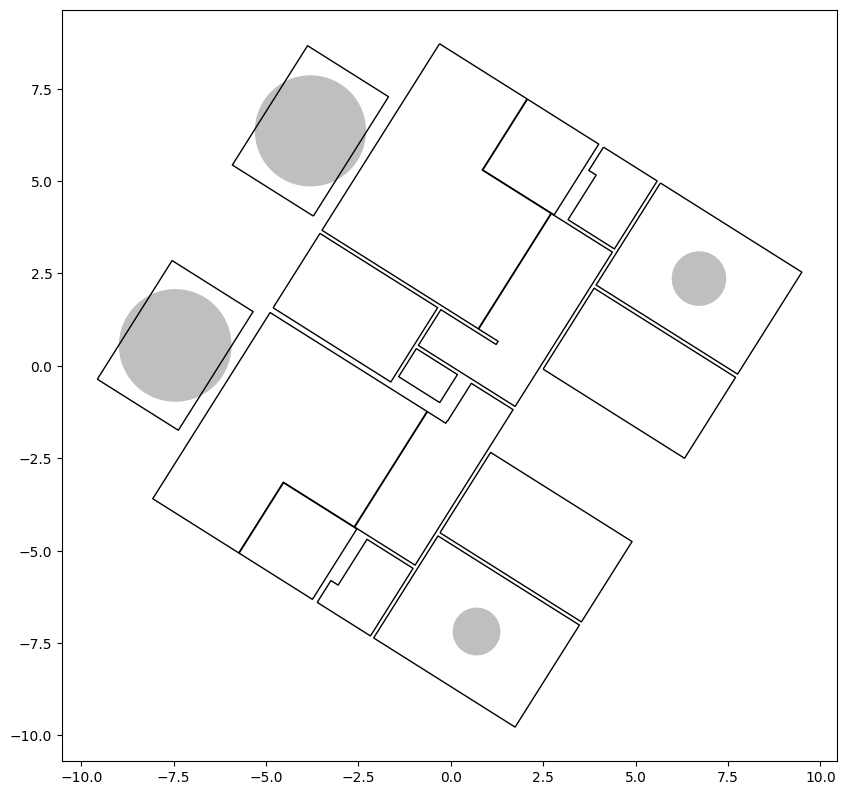

In [31]:
floor = gpd.GeoDataFrame(test_floor, geometry=gs, crs=None)

max_ids_sky = test_floor.iloc[test_floor['view_sky_max'].argsort()[-4:]]
max_ids_sky = max_ids_sky.sort_values(by= 'view_sky_max', ascending=False)
gdf_sky_area = gpd.GeoDataFrame(max_ids_sky, geometry=gs, crs=None)

gdf_sky_area['geometry'].centroid
bounds = floor.total_bounds
x_distance = bounds[2] - bounds[0]
y_distance = bounds[3] - bounds[1]
radius_base = 0.08*max(x_distance, y_distance)
radius = radius_base*(test_floor['view_sky_max'].nlargest(4))
circle = gdf_sky_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles = gpd.GeoDataFrame(circle, geometry=gc, crs=None)

res_symdiff = gdf_circles.overlay(floor, how='identity')
ax = res_symdiff.plot(alpha= 0.5, color = 'Grey',figsize=(10,10))
floor.plot(ax=ax, facecolor='none');

<ipython-input-27-5dcb6c2d4a3b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
<ipython-input-27-5dcb6c2d4a3b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max(

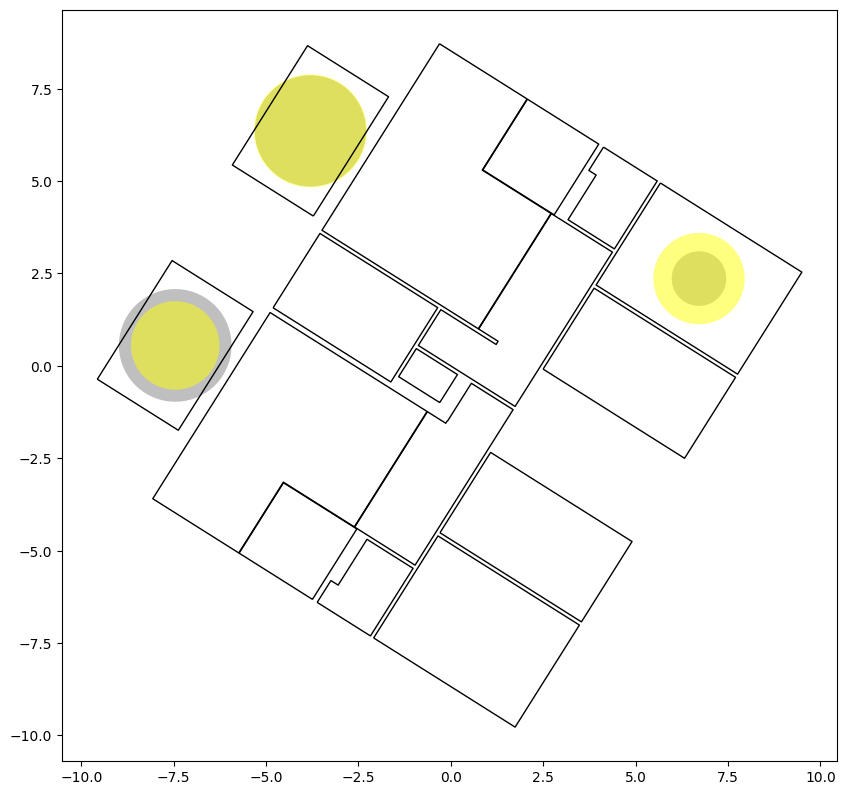

In [27]:
#View Sky
# Normalize using Min/Max Normalization.
test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max()-test_floor['sun_201803211600_max'].min())
test_floor['view_sky_max']=(test_floor['view_sky_max']-test_floor['view_sky_max'].min())/(test_floor['view_sky_max'].max()-test_floor['view_sky_max'].min())
test_floor['view_greenery_max']=(test_floor['view_greenery_max']-test_floor['view_greenery_max'].min())/(test_floor['view_greenery_max'].max()-test_floor['view_greenery_max'].min())
test_floor['window_noise_traffic_day_max']=(test_floor['window_noise_traffic_day_max']-test_floor['window_noise_traffic_day_max'].min())/(test_floor['window_noise_traffic_day_max'].max()-test_floor['window_noise_traffic_day_max'].min())
max_ids_sky = test_floor.iloc[test_floor['view_sky_max'].argsort()[-3:]]
max_ids_sky = max_ids_sky.sort_values(by= 'view_sky_max', ascending=False)
gdf_sky_area = gpd.GeoDataFrame(max_ids_sky, geometry=gs, crs=None)

bounds = floor.total_bounds
x_distance = bounds[2] - bounds[0]
y_distance = bounds[3] - bounds[1]
radius_base = 0.08*max(x_distance, y_distance)
radius = radius_base*(test_floor['view_sky_max'].nlargest(3))
circle = gdf_sky_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles_sky = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_1 = gdf_circles_sky.overlay(floor, how='identity')
ax = identity_1.plot(alpha= 0.5, color = 'Grey',figsize=(10,10))

#Daylight at 8
max_ids_daylight_8 = test_floor.iloc[test_floor['sun_201803210800_max'].argsort()[-3:]]
max_ids_daylight_8 = max_ids_daylight_8.sort_values(by= 'sun_201803210800_max', ascending=False)
gdf_daylight_8_area = gpd.GeoDataFrame(max_ids_daylight_8, geometry=gs, crs=None)

bounds = floor.total_bounds
x_distance = bounds[2] - bounds[0]
y_distance = bounds[3] - bounds[1]
radius_base = 0.08*max(x_distance, y_distance)
radius = radius_base*(test_floor['sun_201803210800_max'].nlargest(3))
circle = gdf_daylight_8_area.centroid.buffer(radius, resolution=16)
gc = gpd.GeoSeries(circle)
gdf_circles_daylight_8 = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_2 = gdf_circles_daylight_8.overlay(floor, how='identity')
ax = identity_2.plot(ax=ax, alpha= 0.5, color = 'Yellow',figsize=(10,10))

floor.plot(ax=ax, facecolor='none');

<ipython-input-38-3caaf793f549>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
<ipython-input-38-3caaf793f549>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max(

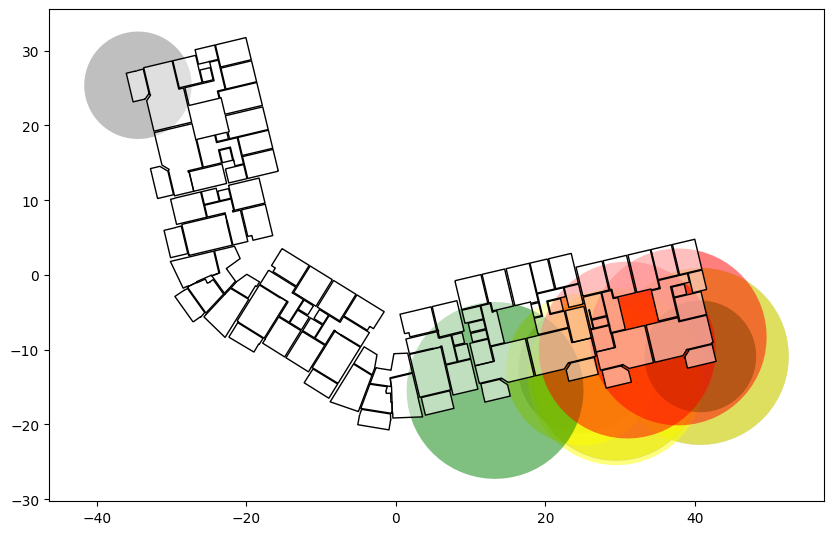

In [38]:
# Normalize using Min/Max Normalization.
test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max()-test_floor['sun_201803211600_max'].min())
test_floor['view_sky_max']=(test_floor['view_sky_max']-test_floor['view_sky_max'].min())/(test_floor['view_sky_max'].max()-test_floor['view_sky_max'].min())
test_floor['view_greenery_max']=(test_floor['view_greenery_max']-test_floor['view_greenery_max'].min())/(test_floor['view_greenery_max'].max()-test_floor['view_greenery_max'].min())
test_floor['window_noise_traffic_day_max']=(test_floor['window_noise_traffic_day_max']-test_floor['window_noise_traffic_day_max'].min())/(test_floor['window_noise_traffic_day_max'].max()-test_floor['window_noise_traffic_day_max'].min())
floor = gpd.GeoDataFrame(test_floor, geometry=gs, crs=None)

bounds = floor.total_bounds
x_distance = bounds[2] - bounds[0]
y_distance = bounds[3] - bounds[1]
radius_base = 0.15*max(x_distance, y_distance)

ncircles_sky = 4
ncircles_daylight = 2
ncircles_greenery = 2
ncircles_noise = 2

#View Sky
max_ids_sky = test_floor.iloc[test_floor['view_sky_max'].argsort()[-ncircles_sky:]]
max_ids_sky = max_ids_sky.sort_values(by= 'view_sky_max', ascending=False)
gdf_sky_area = gpd.GeoDataFrame(max_ids_sky, geometry=gs, crs=None)

radius = radius_base*(test_floor['view_sky_max'].nlargest(ncircles_sky))
circle = gdf_sky_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles_sky = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_1 = gdf_circles_sky.overlay(floor, how='identity')
ax = identity_1.plot(alpha= 0.5, color = 'Grey',figsize=(10,10))

#Daylight at 8
max_ids_daylight_8 = test_floor.iloc[test_floor['sun_201803210800_max'].argsort()[-ncircles_daylight:]]
max_ids_daylight_8 = max_ids_daylight_8.sort_values(by= 'sun_201803210800_max', ascending=False)
gdf_daylight_8_area = gpd.GeoDataFrame(max_ids_daylight_8, geometry=gs, crs=None)

radius = radius_base*(test_floor['sun_201803210800_max'].nlargest(ncircles_daylight))
circle = gdf_daylight_8_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles_daylight_8 = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_2 = gdf_circles_daylight_8.overlay(floor, how='identity')
ax = identity_2.plot(ax=ax, alpha= 0.5, color = 'Yellow',figsize=(10,10))

#Daylight at 16
max_ids_daylight_16 = test_floor.iloc[test_floor['sun_201803211600_max'].argsort()[-ncircles_daylight:]]
max_ids_daylight_16 = max_ids_daylight_16.sort_values(by= 'sun_201803211600_max', ascending=False)
gdf_daylight_16_area = gpd.GeoDataFrame(max_ids_daylight_16, geometry=gs, crs=None)

radius = radius_base*(test_floor['sun_201803211600_max'].nlargest(ncircles_daylight))
circle = gdf_daylight_16_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles_daylight_16 = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_3 = gdf_circles_daylight_16.overlay(floor, how='identity')
ax = identity_3.plot(ax=ax, alpha= 0.5, color = 'Yellow',figsize=(10,10))

#Greenery
max_ids_view_greenery = test_floor.iloc[test_floor['view_greenery_max'].argsort()[-ncircles_greenery:]]
max_ids_view_greenery = max_ids_view_greenery.sort_values(by= 'view_greenery_max', ascending=False)
gdf_view_greenery_area = gpd.GeoDataFrame(max_ids_view_greenery, geometry=gs, crs=None)

radius = radius_base*(test_floor['view_greenery_max'].nlargest(ncircles_greenery))
circle = gdf_view_greenery_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles_greenery = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_4 = gdf_circles_greenery.overlay(floor, how='identity')
ax = identity_4.plot(ax=ax, alpha= 0.5, color = 'Green',figsize=(10,10))


#Noise
max_ids_noise = test_floor.iloc[test_floor['window_noise_traffic_day_max'].argsort()[-ncircles_noise:]]
max_ids_noise = max_ids_noise.sort_values(by= 'window_noise_traffic_day_max', ascending=False)
gdf_noise_area = gpd.GeoDataFrame(max_ids_noise, geometry=gs, crs=None)

radius = radius_base*(test_floor['window_noise_traffic_day_max'].nlargest(ncircles_noise))
circle = gdf_noise_area.centroid.buffer(radius, resolution=16)

gc = gpd.GeoSeries(circle)
gdf_circles_noise = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
identity_5 = gdf_circles_noise.overlay(floor, how='identity')
ax = identity_5.plot(ax=ax, alpha= 0.5, color = 'Red',figsize=(10,10))

identity_6 = floor.overlay(floor, how='identity')
ax = identity_6.plot(ax=ax, alpha= 0.5, color = 'White',figsize=(10,10))
floor.plot(ax=ax, facecolor='none');

In [40]:
#for the dataset
floors_unique = df.floor_id.unique()
floors_unique_df = pd.DataFrame(floors_unique, columns = ['floor_id'])

ncircles_sky = 4
ncircles_daylight = 2
ncircles_greenery = 2
ncircles_noise = 2

x = range(20,60)
for i in x:
  test_floor = df.loc[df['floor_id'] == floors_unique[i]]
  # Normalize using Min/Max Normalization.
  test_floor['sun_201803210800_max']=(test_floor['sun_201803210800_max']-test_floor['sun_201803210800_max'].min())/(test_floor['sun_201803210800_max'].max()-test_floor['sun_201803210800_max'].min())
  test_floor['sun_201803211600_max']=(test_floor['sun_201803211600_max']-test_floor['sun_201803211600_max'].min())/(test_floor['sun_201803211600_max'].max()-test_floor['sun_201803211600_max'].min())
  test_floor['view_sky_max']=(test_floor['view_sky_max']-test_floor['view_sky_max'].min())/(test_floor['view_sky_max'].max()-test_floor['view_sky_max'].min())
  test_floor['view_greenery_max']=(test_floor['view_greenery_max']-test_floor['view_greenery_max'].min())/(test_floor['view_greenery_max'].max()-test_floor['view_greenery_max'].min())
  test_floor['window_noise_traffic_day_max']=(test_floor['window_noise_traffic_day_max']-test_floor['window_noise_traffic_day_max'].min())/(test_floor['window_noise_traffic_day_max'].max()-test_floor['window_noise_traffic_day_max'].min())
  floor = gpd.GeoDataFrame(test_floor, geometry=gs, crs=None)
  
  bounds = floor.total_bounds
  x_distance = bounds[2] - bounds[0]
  y_distance = bounds[3] - bounds[1]
  radius_base = 0.15*max(x_distance, y_distance)

  #View Sky
  max_ids_sky = test_floor.iloc[test_floor['view_sky_max'].argsort()[-ncircles_sky:]]
  max_ids_sky = max_ids_sky.sort_values(by= 'view_sky_max', ascending=False)
  gdf_sky_area = gpd.GeoDataFrame(max_ids_sky, geometry=gs, crs=None)

  radius = radius_base*(test_floor['view_sky_max'].nlargest(ncircles_sky))
  circle = gdf_sky_area.centroid.buffer(radius, resolution=16)

  gc = gpd.GeoSeries(circle)
  gdf_circles_sky = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
  identity_1 = gdf_circles_sky.overlay(floor, how='identity')
  ax = identity_1.plot(alpha= 0.5, color = 'Grey',figsize=(10,10))

  #Daylight at 8
  max_ids_daylight_8 = test_floor.iloc[test_floor['sun_201803210800_max'].argsort()[-ncircles_daylight:]]
  max_ids_daylight_8 = max_ids_daylight_8.sort_values(by= 'sun_201803210800_max', ascending=False)
  gdf_daylight_8_area = gpd.GeoDataFrame(max_ids_daylight_8, geometry=gs, crs=None)

  radius = radius_base*(test_floor['sun_201803210800_max'].nlargest(ncircles_daylight))
  circle = gdf_daylight_8_area.centroid.buffer(radius, resolution=16)

  gc = gpd.GeoSeries(circle)
  gdf_circles_daylight_8 = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
  identity_2 = gdf_circles_daylight_8.overlay(floor, how='identity')
  ax = identity_2.plot(ax=ax, alpha= 0.5, color = 'Yellow',figsize=(10,10))

  #Daylight 16
  max_ids_daylight_16 = test_floor.iloc[test_floor['sun_201803211600_max'].argsort()[-ncircles_daylight:]]
  max_ids_daylight_16 = max_ids_daylight_16.sort_values(by= 'sun_201803211600_max', ascending=False)
  gdf_daylight_16_area = gpd.GeoDataFrame(max_ids_daylight_16, geometry=gs, crs=None)

  radius = radius_base*(test_floor['sun_201803211600_max'].nlargest(ncircles_daylight))
  circle = gdf_daylight_16_area.centroid.buffer(radius, resolution=16)

  gc = gpd.GeoSeries(circle)
  gdf_circles_daylight_16 = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
  identity_3 = gdf_circles_daylight_16.overlay(floor, how='identity')
  ax = identity_3.plot(ax=ax, alpha= 0.5, color = 'Yellow',figsize=(10,10))

  #Greenery
  max_ids_view_greenery = test_floor.iloc[test_floor['view_greenery_max'].argsort()[-ncircles_greenery:]]
  max_ids_view_greenery = max_ids_view_greenery.sort_values(by= 'view_greenery_max', ascending=False)
  gdf_view_greenery_area = gpd.GeoDataFrame(max_ids_view_greenery, geometry=gs, crs=None)

  radius = radius_base*(test_floor['view_greenery_max'].nlargest(ncircles_greenery))
  circle = gdf_view_greenery_area.centroid.buffer(radius, resolution=16)

  gc = gpd.GeoSeries(circle)
  gdf_circles_greenery = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
  identity_4 = gdf_circles_greenery.overlay(floor, how='identity')
  ax = identity_4.plot(ax=ax, alpha= 0.5, color = 'Green',figsize=(10,10))

  #Noise
  max_ids_noise = test_floor.iloc[test_floor['window_noise_traffic_day_max'].argsort()[-ncircles_noise:]]
  max_ids_noise = max_ids_noise.sort_values(by= 'window_noise_traffic_day_max', ascending=False)
  gdf_noise_area = gpd.GeoDataFrame(max_ids_noise, geometry=gs, crs=None)

  radius = radius_base*(test_floor['window_noise_traffic_day_max'].nlargest(ncircles_noise))
  circle = gdf_noise_area.centroid.buffer(radius, resolution=16)

  gc = gpd.GeoSeries(circle)
  gdf_circles_noise = gpd.GeoDataFrame(circle, geometry=gc, crs=None)
  identity_6 = gdf_circles_noise.overlay(floor, how='identity')
  ax = identity_6.plot(ax=ax, alpha= 0.5, color = 'Red',figsize=(10,10))

  identity_7 = floor.overlay(floor, how='identity')
  ax = identity_7.plot(ax=ax, alpha= 0.5, color = 'White',figsize=(10,10))
  floor.plot(ax=ax, facecolor='none');
  fig_name = test_floor['floor_id'].iloc[0]
  continue
  #ax.figure.savefig(fig_name)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_floor['floor_id'].iloc[0]

1927

In [ ]:
fig_name

1927